## Feature Selection to identify objects that most impact visual sentiment

In [31]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=1d750f7fd2722e07bc939f86c3ed09c9ca1c5a8dd8b27bfb525b40df1aa57c36
  Stored in directory: /home/workstation/.cache/pip/wheels/9b/0f/b5/18491a0b635e27a4ca24e38909932443118ce3874d682514a8
Successfully built gdown


In [2]:
###### check gpu
import tensorflow as tf
from tensorflow.python.client import device_lib
import pandas as pd
import numpy as np
import glob
import random
import locale
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.layers import concatenate, Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.utils import plot_model

from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation,Dropout,Dense
from tensorflow.keras.optimizers import Adam

import string
from keras.preprocessing import image as krs_image

# feature selection libraries
from sklearn.feature_selection import RFE

In [3]:
color_gt = ['RGB-R', 'RGB-G','RGB-B','HSL-H','HSL-S','HSL-L']
object_gt = ['aeroplane','apple','backpack','banana','baseball bat','baseball glove','bear','bed','bench','bicycle',
'bird','boat','book','bottle','bowl','broccoli','bus','cake','car','carrot','cat','cell phone','chair',
'clock','cow','cup','diningtable','dog','donut','elephant','fire hydrant','fork','frisbee','giraffe',
'handbag','horse','hot dog','keyboard','kite','knife','laptop','microwave','motorbike','mouse','orange',
'oven','parking meter','person','pizza','pottedplant','refrigerator','remote','sandwich','scissors','sheep',
'sink','skateboard','skis','snowboard','sofa','spoon','sports ball','stop sign','suitcase','surfboard',
'teddy bear','tennis racket','tie','toilet','toothbrush','traffic light','train','truck','tvmonitor','umbrella',
'vase','wine glass','zebra']
scene_gt = ['Indoor/Outdoor','shopping and dining','workplace (office building, factory, lab, etc.)',
'home or hotel','transportation (vehicle interiors, stations, etc.)','sports and leisure','cultural (art, education, religion, millitary, law, politics, etc.)',
'water, ice, snow','mountains, hills, desert, sky','forest, field, jungle','man-made elements','transportation (roads, parking, bridges, boats, airports, etc.)',
'cultural or historical building/place (millitary, religious)','sports fields, parks, leisure spaces','industrial and construction','houses, cabins, gardens, and farms',
'commercial buildings, shops, markets, cities, and towns','airfield','airplane_cabin','airport_terminal','alcove','alley','amphitheater','amusement_arcade',
'amusement_park','apartment_building/outdoor','aquarium','aqueduct','arcade','arch','archaelogical_excavation','archive','arena/hockey','arena/performance',
'arena/rodeo','army_base','art_gallery','art_school','art_studio','artists_loft','assembly_line','athletic_field/outdoor','atrium/public','attic','auditorium',
'auto_factory','auto_showroom','badlands','bakery/shop','balcony/exterior','balcony/interior','ball_pit','ballroom','bamboo_forest','bank_vault','banquet_hall',
'bar','barn','barndoor','baseball_field','basement','basketball_court/indoor','bathroom','bazaar/indoor','bazaar/outdoor','beach','beach_house','beauty_salon',
'bedchamber','bedroom','beer_garden','beer_hall','berth','biology_laboratory','boardwalk','boat_deck','boathouse','bookstore','booth/indoor','botanical_garden',
'bow_window/indoor','bowling_alley','boxing_ring','bridge','bullring','burial_chamber','bus_interior','bus_station/indoor','butchers_shop','butte','cabin/outdoor',
'campsite','campus','canal/natural','canal/urban','candy_store','canyon','car_interior','carrousel','castle','catacomb','cemetery','chalet','chemistry_lab',
'childs_room','church/indoor','church/outdoor','classroom','clean_room','cliff','closet','clothing_store','coast','cockpit','coffee_shop','computer_room',
'conference_center','conference_room','construction_site','corn_field','corral','corridor','cottage','courthouse','courtyard','creek','crevasse','crosswalk',
'dam','delicatessen','department_store','desert/sand','desert/vegetation','desert_road','diner/outdoor','dining_hall','dining_room','discotheque','doorway/outdoor',
'dorm_room','downtown','dressing_room','driveway','drugstore','elevator/door','elevator_lobby','elevator_shaft','embassy','engine_room','entrance_hall',
'escalator/indoor','excavation','fabric_store','farm','fastfood_restaurant','field/cultivated','field/wild','field_road','fire_escape','fire_station','fishpond',
'flea_market/indoor','florist_shop/indoor','food_court','football_field','forest/broadleaf','forest_path','forest_road','formal_garden','fountain','galley',
'garage/indoor','garage/outdoor','gas_station','gazebo/exterior','general_store/indoor','general_store/outdoor','gift_shop','glacier','golf_course','greenhouse/indoor',
'greenhouse/outdoor','grotto','gymnasium/indoor','hangar/indoor','hangar/outdoor','harbor','hardware_store','hayfield','heliport','highway','home_office',
'home_theater','hospital','hospital_room','hot_spring','hotel/outdoor','hotel_room','house','hunting_lodge/outdoor','ice_cream_parlor','ice_floe','ice_shelf',
'ice_skating_rink/indoor','ice_skating_rink/outdoor','iceberg','igloo','industrial_area','inn/outdoor','islet','jacuzzi/indoor','jail_cell','japanese_garden',
'jewelry_shop','junkyard','kasbah','kennel/outdoor','kindergarden_classroom','kitchen','lagoon','lake/natural','landfill','landing_deck','laundromat','lawn',
'lecture_room','legislative_chamber','library/indoor','library/outdoor','lighthouse','living_room','loading_dock','lobby','lock_chamber','locker_room','mansion',
'manufactured_home','market/indoor','market/outdoor','marsh','martial_arts_gym','mausoleum','medina','mezzanine','moat/water','mosque/outdoor','motel','mountain',
'mountain_path','mountain_snowy','movie_theater/indoor','museum/indoor','museum/outdoor','music_studio','natural_history_museum','nursery','nursing_home','oast_house',
'ocean','office','office_building','office_cubicles','oilrig','operating_room','orchard','orchestra_pit','pagoda','palace','pantry','park','parking_garage/indoor',
'parking_garage/outdoor','parking_lot','pasture','patio','pavilion','pet_shop','pharmacy','phone_booth','physics_laboratory','picnic_area','pier','pizzeria','playground',
'playroom','plaza','pond','porch','promenade','pub/indoor','racecourse','raceway','raft','railroad_track','rainforest','reception','recreation_room','repair_shop',
'residential_neighborhood','restaurant','restaurant_kitchen','restaurant_patio','rice_paddy','river','rock_arch','roof_garden','rope_bridge','ruin','runway','sandbox',
'sauna','schoolhouse','science_museum','server_room','shed','shoe_shop','shopfront','shopping_mall/indoor','shower','ski_resort','ski_slope','sky','skyscraper','slum',
'snowfield','soccer_field','stable','stadium/baseball','stadium/football','stadium/soccer','stage/indoor','stage/outdoor','staircase','storage_room','street',
'subway_station/platform','supermarket','sushi_bar','swamp','swimming_hole','swimming_pool/indoor','swimming_pool/outdoor','synagogue/outdoor','television_room',
'television_studio','temple/asia','throne_room','ticket_booth','topiary_garden','tower','toyshop','train_interior','train_station/platform','tree_farm','tree_house',
'trench','tundra','underwater/ocean_deep','utility_room','valley','vegetable_garden','veterinarians_office','viaduct','village','vineyard','volcano',
'volleyball_court/outdoor','waiting_room','water_park','water_tower','waterfall','watering_hole','wave','wet_bar','wheat_field','wind_farm','windmill','yard',
'youth_hostel','zen_garden']

In [16]:
# image features data in csv
train_x_data = pd.read_csv('/media/workstation/2TB/Sidharrth/data/train_x.csv', index_col ='iid')
test_x_data = pd.read_csv('/media/workstation/2TB/Sidharrth/data/test_x.csv',index_col ="iid")
valid_x_data = pd.read_csv('/media/workstation/2TB/Sidharrth/data/valid_x.csv',index_col ="iid")

print()

# rejected_features = color_gt + scene_gt + ['boat', 'car_interior', 'forest, field, jungle', 'forest/broadleaf']
rejected_features = color_gt

train_x_data.drop(columns=rejected_features,inplace=True)
test_x_data.drop(columns=rejected_features,inplace=True)
valid_x_data.drop(columns=rejected_features,inplace=True)

train_y_data = pd.read_csv('/media/workstation/2TB/Sidharrth/data/train_y.csv', index_col ='iid')
test_y_data = pd.read_csv('/media/workstation/2TB/Sidharrth/data/test_y.csv',index_col ="iid")
valid_y_data = pd.read_csv('/media/workstation/2TB/Sidharrth/data/valid_y.csv',index_col ="iid")

train_x_data = train_x_data[train_x_data[object_gt].sum(axis=1) != 0]
test_x_data = test_x_data[test_x_data[object_gt].sum(axis=1) != 0]
valid_x_data = valid_x_data[valid_x_data[object_gt].sum(axis=1) != 0]

train_y_data = train_y_data[train_y_data.index.isin(train_x_data.index)]
test_y_data = test_y_data[test_y_data.index.isin(test_x_data.index)]
valid_y_data = valid_y_data[valid_y_data.index.isin(valid_x_data.index)]

In [18]:
len(train_y_data)

37212

In [19]:
# # data generator

# # Create the arguments for image preprocessing
# data_gen_args = dict(
#     horizontal_flip=True,
#     brightness_range=[0.5, 1.5],
#     shear_range=10,
#     channel_shift_range=50,
#     rescale=1. / 255,
# )

# # Create an empty data generator
# datagen = ImageDataGenerator()

# def my_gen(images_list, dataframe, df_y, batch_size):
#     i = 0
#     while True:
#         batch = {'img_input': [], 'csv_input': [], 'valence': [], 'arousal': [], 'dominance': []}
#         for b in range(batch_size):
#             if i == len(images_list):
#                 i = 0
#                 random.shuffle(images_list)
#             # Read image from list and convert to array
#             image_path = images_list[i]
#             image_name = os.path.basename(image_path).replace('.JPG', '')
#             #image = tf.keras.utils.load_img(image_path, target_size=(224, 224)) 
#             image = krs_image.load_img(image_path, target_size=(224, 224)) #image height & width
#             image = datagen.apply_transform(image, data_gen_args)
#             image = krs_image.img_to_array(image)
#             #image = tf.keras.utils.img_to_array(image)

#             # Read data from csv using the name of current image
#             csv_features = dataframe.loc[image_name, :]
#             y = df_y.loc[image_name, :]
#             val_train = y[0]
#             aro_train = y[1]
#             dom_train = y[2]

#             #print(image_name)
#             batch['img_input'].append(image)
#             batch['csv_input'].append(csv_features)
#             batch['valence'].append(val_train)
#             batch['arousal'].append(aro_train)
#             batch['dominance'].append(dom_train)

#             i += 1

#         batch['img_input'] = np.array(batch['img_input'])
#         batch['csv_input'] = np.array(batch['csv_input'])
#         batch['valence'] = np.array(batch['valence'])
#         batch['arousal'] = np.array(batch['arousal'])
#         batch['dominance'] = np.array(batch['dominance'])
        

#         yield [batch['img_input']], [batch['valence'],batch['arousal'],batch['dominance']]

# gen_train = my_gen(train_file_list, train_x_data, train_y_data, 32)
# gen_test = my_gen(test_file_list, test_x_data, test_y_data, 32)
# gen_valid = my_gen(valid_file_list, valid_x_data, valid_y_data, 32)

In [20]:
def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(512, input_dim=dim, activation="relu", name='csv'))
	model.add(Dense(256, activation="relu"))
	model.add(Dense(128, activation="relu"))
	model.add(Dense(64, activation="relu"))    
    
	return model

In [21]:
from tensorflow.keras.applications.resnet import ResNet50

def create_resnet(width, height, depth):
    inputs= Input(shape=(width, height, depth), name='img_input')  

    res = ResNet50(
        weights='imagenet',  
        include_top=False,  
        input_tensor = inputs,  
    )

    for layer in res.layers:  
        layer.trainable = False #false: freeze, true:train by own

    x = layers.BatchNormalization()(res.output)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)

    model = Model(res.input, x, name="ResNet")
    return model

In [22]:
# resnet = create_resnet(224, 224, 3)
# resnet.summary()

In [24]:
from tensorflow.keras.optimizers import Adam

mlp = create_mlp(train_x_data.shape[1])

valence_output = Dense(units=1, activation='sigmoid', name='valence_output')(mlp.output)
arousal_output = Dense(units=1, activation='sigmoid', name='arousal_output')(mlp.output)
dominance_output = Dense(units=1, activation='sigmoid', name='dominance_output')(mlp.output)

model = Model(inputs=[mlp.input], outputs=[valence_output, arousal_output, dominance_output])

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, run_eagerly=True,
              loss={'valence_output': 'mse', 'arousal_output': 'mse', 'dominance_output': 'mse'},
              metrics={'valence_output': 'mae', 'arousal_output': 'mae', 'dominance_output': 'mae'})

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
csv_input (InputLayer)          [(None, 458)]        0                                            
__________________________________________________________________________________________________
csv (Dense)                     (None, 512)          235008      csv_input[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          131328      csv[0][0]                        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
_______________________________________________________________________________________

In [28]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('./trained_models/MLPWithout0s', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

batch_size = 32
# trainidx = len(train_file_list)
# testidx = len(test_file_list)
# valididx = len(valid_file_list)

In [29]:
# train_y_data = (train_y_data / 9)
# valid_y_data = (valid_y_data / 9)
# test_y_data = (test_y_data / 9) 

inance_output_loss: 17.4509 - valence_output_mae: 4.0810 - arousal_output_mae: 4.0810 - dominance_output_mae: 4.0810
Epoch 00009: val_loss did not improve from 52.08889
1163/1163 [==============================] - 28s 24ms/step - loss: 52.3530 - valence_output_loss: 17.4510 - arousal_output_loss: 17.4510 - dominance_output_loss: 17.4510 - valence_output_mae: 4.0810 - arousal_output_mae: 4.0810 - dominance_output_mae: 4.0810 - val_loss: 52.0889 - val_valence_output_loss: 17.3630 - val_arousal_output_loss: 17.3630 - val_dominance_output_loss: 17.3630 - val_valence_output_mae: 4.0723 - val_arousal_output_mae: 4.0723 - val_dominance_output_mae: 4.0723
Epoch 10/1000
1162/1163 [============================>.] - ETA: 0s - loss: 52.3555 - valence_output_loss: 17.4518 - arousal_output_loss: 17.4518 - dominance_output_loss: 17.4518 - valence_output_mae: 4.0811 - arousal_output_mae: 4.0811 - dominance_output_mae: 4.0811
Epoch 00010: val_loss did not improve from 52.08889
1163/1163 [==============

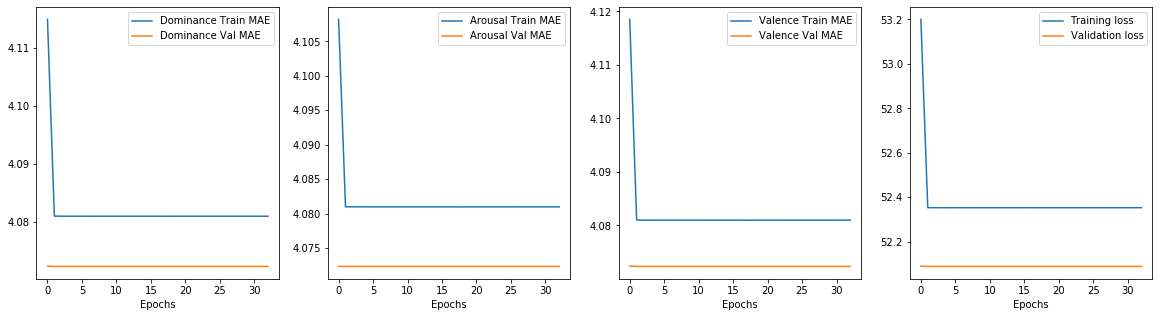

In [30]:
history = model.fit(train_x_data, train_y_data, epochs=1000, validation_data=(valid_x_data, valid_y_data), callbacks=callbacks, batch_size=32)

def plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['dominance_output_mae'], label='Dominance Train MAE')
    axes[0].plot(history.history['val_dominance_output_mae'], label='Dominance Val MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['arousal_output_mae'], label='Arousal Train MAE')
    axes[1].plot(history.history['val_arousal_output_mae'], label='Arousal Val MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['valence_output_mae'], label='Valence Train MAE')
    axes[2].plot(history.history['val_valence_output_mae'], label='Valence Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

model.save('b4_mixedinput_fc_1024_512.h5')